In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
# classes = [0, 4, 9]
# branch_defs = [
#     ((0, 4, 9), 500, 1000),
#     ((0,), 0, 500),
#     ((4, 9), 300, 500),
#     ((4,), 0, 300),
#     ((9,), 0, 300)
# ]

classes = [0]
branch_defs = [
    ((0,), 0, 1000)
]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Create the model

In [5]:
# Create the diffuser and model
diffuser = discrete_diffusers.GaussianDiffuser(1e-4, 1e-5, input_shape)

t_limit = 1000

model = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs), t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/test_discrete"

import model.train_discrete_model as train_discrete_model  # Import this AFTER setting environment

### Show the forward-diffusion process

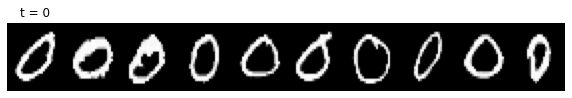

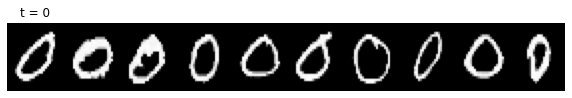

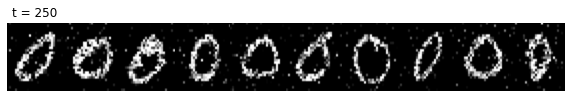

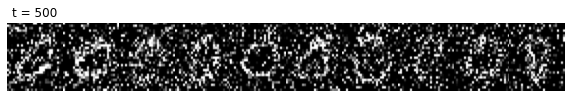

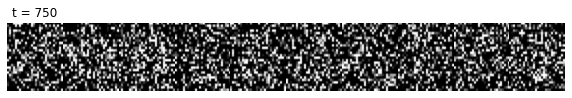

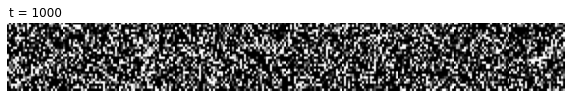

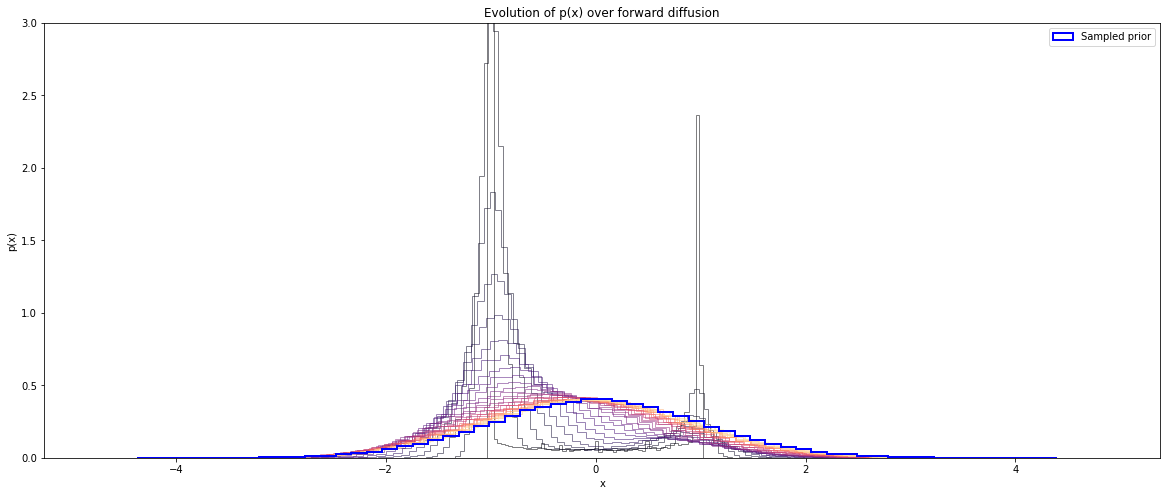

In [6]:
# Show some images after running the diffuser forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.arange(0, t_limit + 1, t_limit // time_steps):
    xt, score = diffuser.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %d" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = diffuser.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = diffuser.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward diffusion")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [7]:
train_discrete_model.train_ex.run(
    "train_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 100,
        "learning_rate": 0.001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_model'
INFO - train - Started run with ID "71"
Loss: 221.77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 1 average Loss: 761.44


Loss: 142.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.31it/s]


Epoch 2 average Loss: 199.16


Loss: 183.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.54it/s]


Epoch 3 average Loss: 164.56


Loss: 186.21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.76it/s]


Epoch 4 average Loss: 132.53


Loss: 134.76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.59it/s]


Epoch 5 average Loss: 114.48


Loss: 111.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.78it/s]


Epoch 6 average Loss: 122.11


Loss: 106.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.45it/s]


Epoch 7 average Loss: 112.54


Loss: 86.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.69it/s]


Epoch 8 average Loss: 105.36


Loss: 82.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.65it/s]


Epoch 9 average Loss: 93.79


Loss: 117.14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.85it/s]


Epoch 10 average Loss: 89.23


Loss: 95.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.63it/s]


Epoch 11 average Loss: 88.00


Loss: 88.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.72it/s]


Epoch 12 average Loss: 78.89


Loss: 91.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.61it/s]


Epoch 13 average Loss: 78.10


Loss: 86.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.59it/s]


Epoch 14 average Loss: 75.65


Loss: 109.81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.73it/s]


Epoch 15 average Loss: 75.49


Loss: 68.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.65it/s]


Epoch 16 average Loss: 71.72


Loss: 68.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.76it/s]


Epoch 17 average Loss: 68.37


Loss: 75.86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.66it/s]


Epoch 18 average Loss: 70.48


Loss: 73.68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.30it/s]


Epoch 19 average Loss: 68.49


Loss: 74.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.68it/s]


Epoch 20 average Loss: 68.68


Loss: 73.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.45it/s]


Epoch 21 average Loss: 65.34


Loss: 66.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.47it/s]


Epoch 22 average Loss: 65.73


Loss: 58.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.42it/s]


Epoch 23 average Loss: 62.67


Loss: 43.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.27it/s]


Epoch 24 average Loss: 60.11


Loss: 48.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.52it/s]


Epoch 25 average Loss: 58.54


Loss: 55.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.47it/s]


Epoch 26 average Loss: 61.57


Loss: 78.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.89it/s]


Epoch 27 average Loss: 60.85


Loss: 57.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.62it/s]


Epoch 28 average Loss: 61.15


Loss: 69.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.43it/s]


Epoch 29 average Loss: 59.37


Loss: 102.10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.81it/s]


Epoch 30 average Loss: 57.61


Loss: 52.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.45it/s]


Epoch 31 average Loss: 57.16


Loss: 72.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.92it/s]


Epoch 32 average Loss: 55.15


Loss: 55.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.56it/s]


Epoch 33 average Loss: 55.52


Loss: 49.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.68it/s]


Epoch 34 average Loss: 56.49


Loss: 65.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.51it/s]


Epoch 35 average Loss: 54.52


Loss: 54.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.59it/s]


Epoch 36 average Loss: 55.40


Loss: 67.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.03it/s]


Epoch 37 average Loss: 55.03


Loss: 61.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.20it/s]


Epoch 38 average Loss: 53.85


Loss: 53.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.29it/s]


Epoch 39 average Loss: 52.75


Loss: 60.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.69it/s]


Epoch 40 average Loss: 52.54


Loss: 39.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.40it/s]


Epoch 41 average Loss: 50.69


Loss: 35.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.53it/s]


Epoch 42 average Loss: 53.07


Loss: 80.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.17it/s]


Epoch 43 average Loss: 50.55


Loss: 31.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.38it/s]


Epoch 44 average Loss: 51.40


Loss: 62.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.39it/s]


Epoch 45 average Loss: 52.76


Loss: 55.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.38it/s]


Epoch 46 average Loss: 51.29


Loss: 44.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.43it/s]


Epoch 47 average Loss: 50.87


Loss: 89.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.56it/s]


Epoch 48 average Loss: 51.52


Loss: 54.58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.51it/s]


Epoch 49 average Loss: 50.43


Loss: 53.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.17it/s]


Epoch 50 average Loss: 48.40


Loss: 68.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.67it/s]


Epoch 51 average Loss: 49.12


Loss: 91.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.18it/s]


Epoch 52 average Loss: 49.25


Loss: 51.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.46it/s]


Epoch 53 average Loss: 47.54


Loss: 65.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.62it/s]


Epoch 54 average Loss: 48.50


Loss: 33.83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.32it/s]


Epoch 55 average Loss: 47.69


Loss: 46.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.50it/s]


Epoch 56 average Loss: 48.57


Loss: 57.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.95it/s]


Epoch 57 average Loss: 47.24


Loss: 41.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.30it/s]


Epoch 58 average Loss: 47.66


Loss: 54.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.42it/s]


Epoch 59 average Loss: 47.38


Loss: 36.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.65it/s]


Epoch 60 average Loss: 45.78


Loss: 58.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.26it/s]


Epoch 61 average Loss: 47.50


Loss: 53.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.65it/s]


Epoch 62 average Loss: 46.83


Loss: 37.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.28it/s]


Epoch 63 average Loss: 46.05


Loss: 40.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.18it/s]


Epoch 64 average Loss: 46.45


Loss: 39.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.98it/s]


Epoch 65 average Loss: 46.35


Loss: 46.30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.65it/s]


Epoch 66 average Loss: 46.52


Loss: 40.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.32it/s]


Epoch 67 average Loss: 45.43


Loss: 37.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.52it/s]


Epoch 68 average Loss: 46.87


Loss: 58.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.54it/s]


Epoch 69 average Loss: 45.77


Loss: 48.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.22it/s]


Epoch 70 average Loss: 44.72


Loss: 56.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.51it/s]


Epoch 71 average Loss: 44.46


Loss: 45.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.41it/s]


Epoch 72 average Loss: 45.19


Loss: 37.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.18it/s]


Epoch 73 average Loss: 43.83


Loss: 66.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.40it/s]


Epoch 74 average Loss: 44.87


Loss: 48.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.66it/s]


Epoch 75 average Loss: 43.86


Loss: 39.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.79it/s]


Epoch 76 average Loss: 43.75


Loss: 27.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.78it/s]


Epoch 77 average Loss: 43.68


Loss: 53.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.65it/s]


Epoch 78 average Loss: 44.22


Loss: 42.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.71it/s]


Epoch 79 average Loss: 43.09


Loss: 65.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.48it/s]


Epoch 80 average Loss: 44.30


Loss: 54.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.52it/s]


Epoch 81 average Loss: 44.05


Loss: 44.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.51it/s]


Epoch 82 average Loss: 41.90


Loss: 33.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.74it/s]


Epoch 83 average Loss: 41.82


Loss: 51.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.53it/s]


Epoch 84 average Loss: 43.31


Loss: 42.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.70it/s]


Epoch 85 average Loss: 42.53


Loss: 43.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.49it/s]


Epoch 86 average Loss: 43.51


Loss: 42.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.44it/s]


Epoch 87 average Loss: 42.56


Loss: 34.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.27it/s]


Epoch 88 average Loss: 42.22


Loss: 33.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.30it/s]


Epoch 89 average Loss: 42.38


Loss: 42.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.54it/s]


Epoch 90 average Loss: 41.60


Loss: 52.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.59it/s]


Epoch 91 average Loss: 42.06


Loss: 51.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.71it/s]


Epoch 92 average Loss: 42.38


Loss: 43.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.63it/s]


Epoch 93 average Loss: 42.30


Loss: 52.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.26it/s]


Epoch 94 average Loss: 41.62


Loss: 70.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.82it/s]


Epoch 95 average Loss: 42.37


Loss: 33.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.02it/s]


Epoch 96 average Loss: 41.30


Loss: 47.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.94it/s]


Epoch 97 average Loss: 42.76


Loss: 31.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.14it/s]


Epoch 98 average Loss: 42.13


Loss: 43.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.70it/s]


Epoch 99 average Loss: 42.34


Loss: 36.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.79it/s]
INFO - train - Completed after 0:03:45


Epoch 100 average Loss: 40.16


### Show generated digits

Sampling class: 0


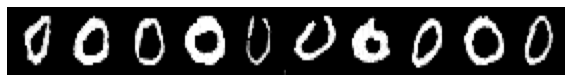

In [8]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_discrete_samples(
        model, diffuser, class_to_sample, class_time_to_branch_tensor,
        t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

**Intermediate states**

In [ ]:
samples_49 = generate.generate_discrete_samples(
    model, diffuser, 4, class_time_to_branch_tensor, t_start=300,
    t_limit=t_limit
).cpu().numpy()
samples_4 = generate.generate_discrete_samples(
    model, diffuser, 4, class_time_to_branch_tensor, t_limit=300,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()
samples_9 = generate.generate_discrete_samples(
    model, diffuser, 9, class_time_to_branch_tensor, t_limit=300,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()

smoothed_samples_49 = np.empty_like(samples_49)
for i in range(len(samples_49)):
    smoothed_samples_49[i, 0] = scipy.ndimage.gaussian_filter(samples_49[i, 0], sigma=1)
    
plot_mnist_digits(smoothed_samples_49)
plot_mnist_digits(samples_4)
plot_mnist_digits(samples_9)

**Diffusing from one class to another**

In [ ]:
orig_4 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
])
orig_9 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
])

time_steps = 10
all_t = np.arange(0, 300 + 1, 300 // time_steps)
forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
for t_i, t in enumerate(all_t):
    forward_4_to_9[t_i] = diffuser.forward(
        orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_9_to_4[t_i] = diffuser.forward(
        orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_4_to_9 = generate.generate_discrete_samples(
        model, diffuser, 9, class_time_to_branch_tensor,
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_4.shape[0], initial_samples=last_4_to_9
    )
    backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
    last_9_to_4 = generate.generate_discrete_samples(
        model, diffuser, 4, class_time_to_branch_tensor,
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_9.shape[0], initial_samples=last_9_to_4
    )
    backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
print("4 to 9")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

print("9 to 4")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))